In [1]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.autonotebook import tqdm
import quantus

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')


from datasets.datamodules import CIFAR10DataModule, GastroDataModule, DataModuleWithMasks, GenerateMasksKwargs
from lightning_modules.explainer import Explainer
from lightning_modules.surrogate import Surrogate
from vit_shapley.masks import apply_masks_to_batch, remake_masks, quick_test_masked
from vit_shapley.visualizations import get_heatmaps_grid

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(3)

/tmp/ipykernel_8728/3699759834.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
datamodule = DataModuleWithMasks(
    CIFAR10DataModule(),
    GenerateMasksKwargs(num_players=16),
    dict(batch_size=32)
)
datamodule.setup("test")
data = next(iter(datamodule.test_dataloader()))

images = data['image']
labels = data['label']
masks = data['mask']
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 16])


# Loading models

In [3]:
surrogates = {"swin": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/cifar10/v4/player196/swin_tiny_patch4_window7_224",
    map_location="cuda"
),
"vit": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/cifar10/v4/player196/vit_small_patch16_224",
    map_location="cuda"
),
"t2t_vit": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/cifar10/v4/player196/t2t_vit_14",
    map_location="cuda"
)}

for surrogate in surrogates.values():
    surrogate.eval()

adopt performer encoder for tokens-to-token


In [4]:
explainers = {"swin": Explainer.load_from_latest_checkpoint(
    "saved_models/explainer/cifar10/v4/player196/swin_tiny_patch4_window7_224",
    map_location="cuda",
    surrogate=deepcopy(surrogates["swin"])
),
"vit": Explainer.load_from_latest_checkpoint(
    "saved_models/explainer/cifar10/v4/player196/vit_small_patch16_224",
    map_location="cuda",
    surrogate=deepcopy(surrogates["vit"])
),
"t2t_vit": Explainer.load_from_latest_checkpoint(
    "saved_models/explainer/cifar10/v4/player196/t2t_vit_14",
    map_location="cuda",
    surrogate=deepcopy(surrogates["t2t_vit"])
),}

for explainer in explainers.values():
    explainer.eval()
    pass

# Explainer visualization

In [7]:
shap_values = {}

for model_name, explainer in explainers.items():
    with torch.no_grad():
        shap_values_ = explainer(images.to(explainer.device)).cpu()  # (batch=32, num_players=196, num_classes=10)
    shap_values[model_name] = shap_values_[torch.arange(shap_values_.shape[0]), :, labels] # (batch, num_players)


## Quantus

In [9]:
import quantus
metric = quantus.MaxSensitivity(nr_samples=10,
                                lower_bound=0.2,
                                # norm_numerator=quantus.fro_norm,
                                # norm_denominator=quantus.fro_norm,
                                perturb_func=quantus.uniform_noise,
                                similarity_func=quantus.difference,
                                abs=True,
                                normalise=True)

In [10]:
import captum
from captum.attr import Saliency, IntegratedGradients

def add_softmax_layer(surrogate):
    surrogate_prob = torch.nn.Sequential(
        surrogate,
        torch.nn.Softmax(dim=1))
    return surrogate_prob

surrogates_prob = {}
for model_name, surrogate in surrogates.items():
    surrogates_prob[model_name] = add_softmax_layer(surrogate)
    surrogates_prob[model_name].eval()

a_batch_saliency = {}
a_batch_intgrad = {}

# quantus.normalise_by_negative(Saliency(surrogates_prob[model_name].cpu()).attribute(inputs=images, target=labels, abs=True).sum(axis=1).c

for model_name in ["t2t_vit", "vit", "swin"]:
    a_batch_saliency[model_name] = Saliency(surrogates_prob[model_name].cpu()).attribute(inputs=images, target=labels, abs=True)
    a_batch_intgrad[model_name] = IntegratedGradients(surrogates_prob[model_name].cpu()).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy()
    print(a_batch_saliency)
    print(a_batch_intgrad)


/home/j.rutkowski2/magisterka/T2T_ViT/condaenv/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


{'t2t_vit': tensor([[[[4.1665e-06, 3.2679e-06, 3.2299e-06,  ..., 3.5473e-06,
           2.3772e-06, 2.4966e-06],
          [1.0665e-06, 5.1675e-06, 3.3841e-06,  ..., 9.2668e-07,
           1.4586e-06, 2.8661e-06],
          [2.0285e-06, 4.5236e-06, 5.8704e-07,  ..., 1.9692e-06,
           2.5595e-06, 1.7775e-06],
          ...,
          [9.8815e-07, 6.0299e-06, 7.7778e-07,  ..., 6.1171e-07,
           1.2654e-06, 9.4545e-07],
          [5.9510e-06, 1.2967e-06, 3.7340e-06,  ..., 1.2978e-06,
           1.5068e-07, 2.3005e-06],
          [6.2356e-06, 5.0663e-06, 1.5242e-06,  ..., 2.8032e-07,
           5.0796e-07, 2.8315e-06]],

         [[1.7729e-06, 8.9503e-06, 5.3134e-07,  ..., 6.0381e-06,
           4.8338e-06, 2.3257e-06],
          [9.1909e-06, 7.2040e-06, 4.8952e-06,  ..., 2.9182e-06,
           2.8998e-06, 5.8635e-07],
          [8.8565e-06, 4.9158e-06, 1.2519e-05,  ..., 4.3171e-07,
           3.7836e-06, 6.8141e-06],
          ...,
          [5.3315e-06, 7.5599e-06, 9.0523e-07, 

In [11]:
print(a_batch_saliency["vit"].shape, a_batch_intgrad["vit"].shape)

torch.Size([32, 3, 224, 224]) (32, 224, 224)


## Compute monotonicity metric for:
- saliency
- integrated gradients
- shapley values computed with explainer
- (for 16 players) shapley values ground truth

In [12]:
monotonicity_metric = quantus.metrics.faithfulness.monotonicity.Monotonicity()

In [ ]:
saliency_eval = {}
for model_name in ["t2t_vit", "vit", "swin"]:
    saliency_eval[model_name] = monotonicity_metric(surrogates_prob[model_name], images, labels, a_batch_saliency[model_name].detach().numpy())
    print(f'Computed for {model_name}')

In [ ]:
intgrad_eval = {}
for model_name in ["t2t_vit", "vit", "swin"]:
    intgrad_eval[model_name] = monotonicity_metric(surrogates_prob[model_name], images, labels, a_batch_intgrad[model_name].detach().numpy())
    print(f'Computed for {model_name}')

In [ ]:
shapley_eval = {}
for model_name in ["t2t_vit", "vit", "swin"]:
    shapley_eval[model_name] = monotonicity_metric(surrogates_prob[model_name], images, labels, shapley_values[model_name].detach().numpy())
    print(f'Computed for {model_name}')

In [8]:
metric = quantus.MaxSensitivity()

In [9]:
a_batch_intgrad = quantus.explain(surrogatse_prob, images, labels, method="IntegratedGradients")

In [10]:
def normalize_image(arr) -> np.ndarray:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    if isinstance(arr, torch.Tensor):
        arr_copy = arr.clone().cpu().numpy()
    else:
        arr_copy = arr.copy()

    arr_copy = quantus.normalise_func.denormalise(arr_copy, mean=mean, std=std)
    arr_copy  = np.moveaxis(arr_copy, 0, -1)
    arr_copy = (arr_copy * 255.).astype(np.uint8)
    return arr_copy

In [11]:
a_batch_intgrad[0].shape

(1, 224, 224)

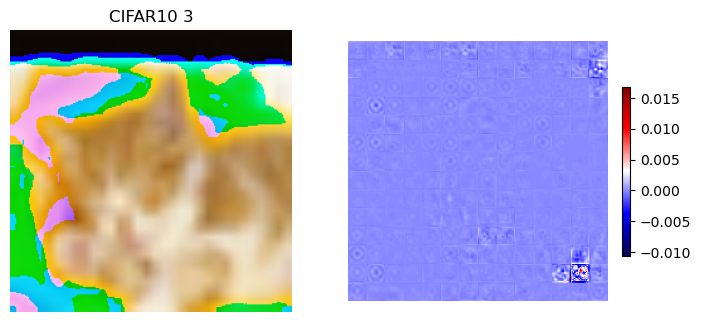

In [12]:
import random
index = random.randint(0, len(images)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(normalize_image(images[index].detach()), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"CIFAR10 {labels[index].item()}")
exp = axes[1].imshow(a_batch_intgrad[index].reshape(224, 224), cmap="seismic")
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show();

In [ ]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
monotonicity_correlation = quantus.MonotonicityCorrelation(
    nr_samples=10,
    features_in_step=3136,
    perturb_baseline="uniform",
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
    similarity_func=quantus.similarity_func.correlation_spearman,
)(model=surrogate,
   x_batch=images.detach().numpy(),
   y_batch=labels,
   a_batch=a_batch_intgrad)

In [11]:
shap_values_quantus = shap_values.view(32, 14, 14).repeat_interleave(16, dim=1).repeat_interleave(16, dim=2).unsqueeze(1) #.repeat(1,3,1,1)

In [ ]:
import quantus

params_eval = {
    "nr_samples": 10,
    "perturb_radius": 0.1,
    # "norm_numerator": quantus.fro_norm,
    # "norm_denominator": quantus.fro_norm,
    # "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
    "disable_warnings": True}

# **params_eval
scores_saliency = quantus.MaxSensitivity()(model=surrogate.cpu(), 
                                                        x_batch=images.cpu().detach().numpy(),
                                                        y_batch=labels.cpu().detach().numpy(),
                                                        a_batch=shap_values_quantus.cpu().detach().numpy(),
                                                        explain_func=quantus.explain)